torch.Size([60000, 28, 28])
raw tensor(78.5373)
augmented shape torch.Size([200000, 28, 28])
augmentsd tensor(75.9512)
tensor(-0.9961)
tensor(-0.9961)


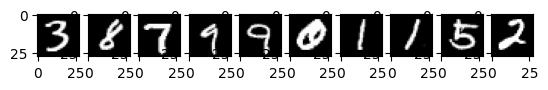

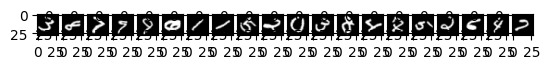

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pandas
import torchvision
from torchvision import transforms
import itertools
import torchviz

torch.manual_seed(1337)


# device = torch.device("mps")
# torch.set_default_device(device)

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))
# raw_data = mnist_trainset.data.float().to(device)
# labels = mnist_trainset.targets.to(device)
raw_data = mnist_trainset.data.float()
labels = mnist_trainset.targets


print(raw_data.shape)
val_feat = raw_data[0:10000]
train_feat = raw_data[10000:]
print("raw", torch.std(train_feat))
aug_feat = train_feat.clone().detach()
for i in range(3):
    aug_feat = torch.cat((aug_feat, transforms.Compose([
        transforms.RandomRotation([-45, 45], interpolation=transforms.InterpolationMode.BILINEAR, fill=0)
    ])(train_feat)))

aug_feat.detach()
print("augmented shape", aug_feat.shape)
print("augmentsd", torch.std(aug_feat))


features = (aug_feat - 127.5) / 128.0
print(features[50001][0][0])
print(features[0][0][0])

f, axrr = plt.subplots(1, 10)
for i in range(10):
    img = features[i].squeeze(0) / 127 + 127.5
    axrr[i].imshow(img.detach().cpu().numpy(), cmap='gray')
plt.show()
f, axrr = plt.subplots(1, 20)
for i in range(20):
    img = features[i + 50000].squeeze(0) / 127 + 127.5
    axrr[i].imshow(img.detach().cpu().numpy(), cmap='gray')
plt.show()


# features = (mnist_trainset.data.float() - 127.5) / 128.0
# labels = mnist_trainset.targets

In [2]:
class SimpleGenerator(nn.Module):
    def __init__(self, zdim):
        super().__init__()

        self.model = nn.Sequential(
            *self.layer(zdim, 128, False),
            *self.layer(128, 256),
            *self.layer(256, 512),
            *self.layer(512, 1024),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()   # use tanh because the discriminator expects -1..1
        )
 
    def layer(self, in_c, out_c, norm=True):
        l = [
            nn.Linear(in_c, out_c, bias=not norm),
        ]
        if not norm:
            l[0].name = "First"
        if norm:
            l.append(nn.BatchNorm1d(out_c, 0.8))
        l.append(nn.LeakyReLU(0.2))
        return l       

    def forward(self, d):
        d = self.model(d)
        return d.view(-1, 1, 28, 28)
        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, padding="same")
        self.conv2 = torch.nn.Conv2d(16, 16, 5, padding="same")
        n = 28 * 28 // 4 // 4 * 16
        self.dense1 = torch.nn.Linear(n, n // 2)
        self.dense2 = torch.nn.Linear(n // 2, n // 4)
        self.logits = torch.nn.Linear(n // 4, 1)

    def forward(self, x):
        v = self.conv1(x)
        v = F.relu(v)
        v = F.max_pool2d(v, 2)
        v = F.dropout(v, 0.3)
        v = self.conv2(v)
        v = F.leaky_relu(v, 0.2)
        v = F.max_pool2d(v, 2)
        v = F.dropout(v, 0.3)
        v = torch.flatten(v, 1)
        v = self.dense1(v)
        v = F.leaky_relu(v, 0.2)
        v = self.dense2(v)
        v = F.leaky_relu(v, 0.2)
        v = self.logits(v)
        
        return v.sigmoid()
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(-1, 28 * 28)
        validity = self.model(img_flat)
        return validity

    
class Generator(nn.Module):
    def __init__(self, zdim):
        super().__init__()
        channels = self.channels = 16
        self.dd1 = torch.nn.Linear(zdim, 7 * 7 * channels)
        self.deconv1 = torch.nn.ConvTranspose2d(channels, channels, 4, 2, padding=1)
        self.deconv2 = torch.nn.ConvTranspose2d(channels, 1, 4, 2, padding=1)


    def forward(self, x):
        d = self.dd1(x)
        d = d.view(-1, self.channels, 7, 7)
        d = self.deconv1(d)
        d = F.leaky_relu(d, 0.2)
        d = self.deconv2(d)
        d = F.tanh(d)

        return d

torch.Size([200000, 28, 28])
Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=128, out_features=256, bias=False)
  (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Linear(in_features=256, out_features=512, bias=False)
  (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Linear(in_features=512, out_features=1024, bias=False)
  (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2)
  (11): Linear(in_features=1024, out_features=784, bias=True)
  (12): Tanh()
)


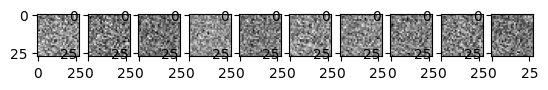

dloss: 0.696072, gloss: 0.723671


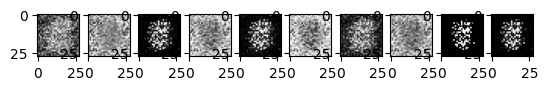

dloss: 0.423454, gloss: 1.113104


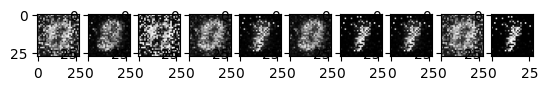

dloss: 0.365429, gloss: 1.033535


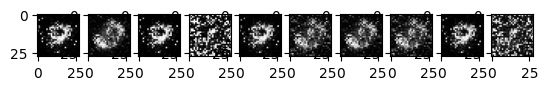

dloss: 0.373863, gloss: 1.051750


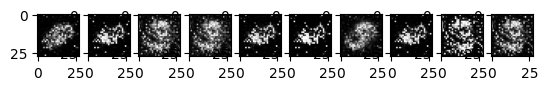

dloss: 0.377377, gloss: 0.886078


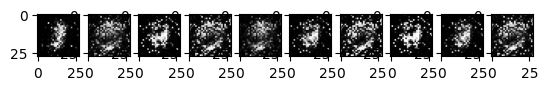

dloss: 0.340078, gloss: 0.907599


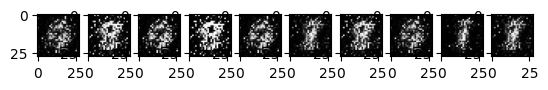

dloss: 0.409031, gloss: 1.991699


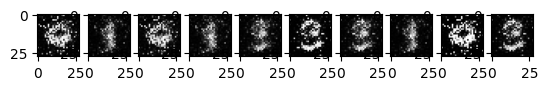

dloss: 0.341940, gloss: 2.243658


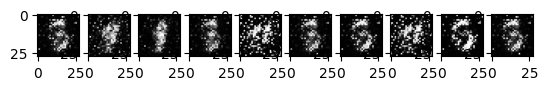

dloss: 0.317857, gloss: 1.863813


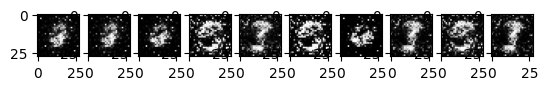

dloss: 0.272366, gloss: 1.522488


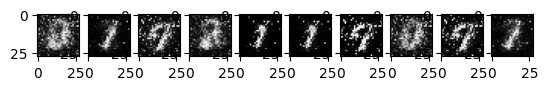

dloss: 0.289310, gloss: 1.722706


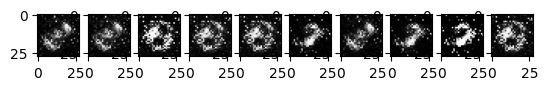

dloss: 0.326171, gloss: 1.709008


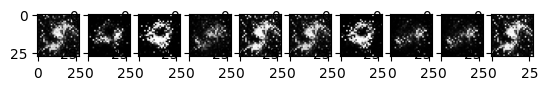

dloss: 0.276193, gloss: 1.087743


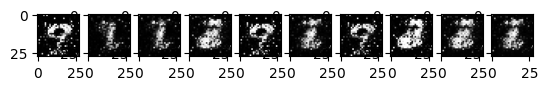

dloss: 0.245440, gloss: 1.305715


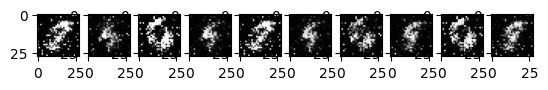

dloss: 0.185329, gloss: 2.390179


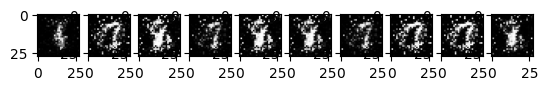

dloss: 0.211626, gloss: 1.486712


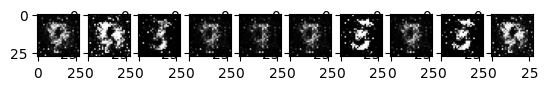

dloss: 0.235618, gloss: 1.652313


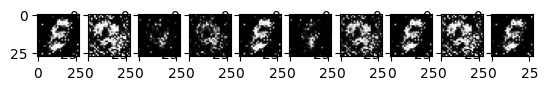

dloss: 0.163573, gloss: 2.384329


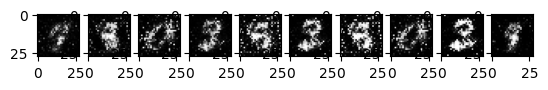

dloss: 0.237131, gloss: 1.399078


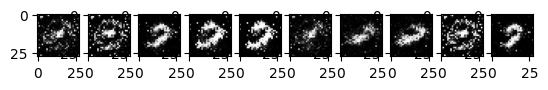

dloss: 0.256158, gloss: 1.340899


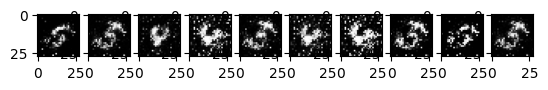

dloss: 0.267812, gloss: 1.296858


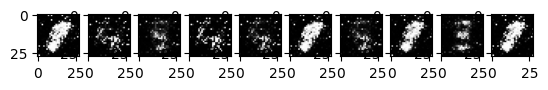

dloss: 0.418458, gloss: 4.764294


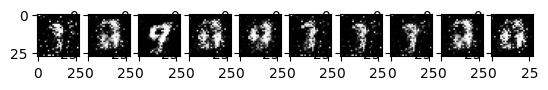

dloss: 0.213408, gloss: 1.944389


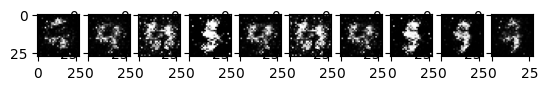

dloss: 0.330352, gloss: 1.086224


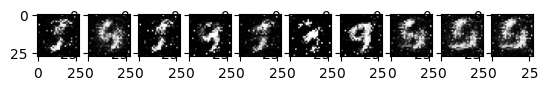

dloss: 0.314356, gloss: 1.813030


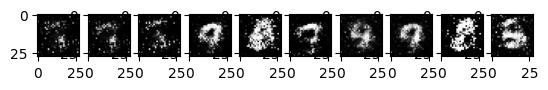

dloss: 0.377022, gloss: 3.295514


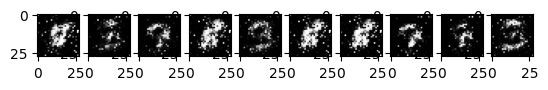

dloss: 0.272261, gloss: 1.264624


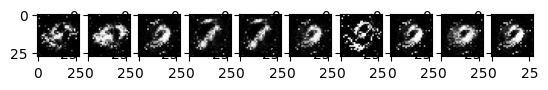

dloss: 0.294245, gloss: 1.483773


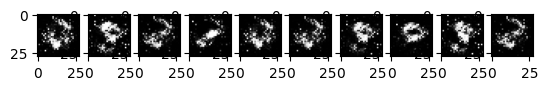

dloss: 0.428311, gloss: 1.166960


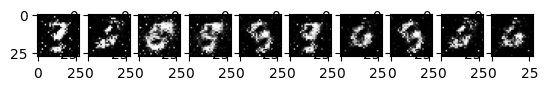

dloss: 0.301515, gloss: 1.789224


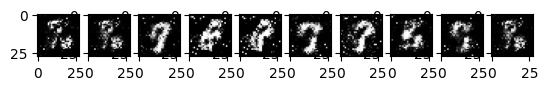

dloss: 0.410587, gloss: 3.507948


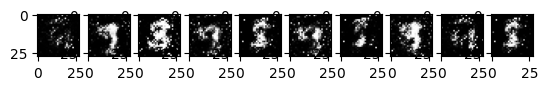

dloss: 0.207249, gloss: 2.099606


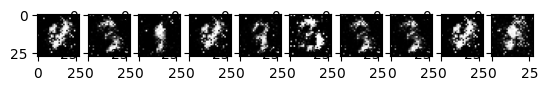

dloss: 0.321963, gloss: 1.129766


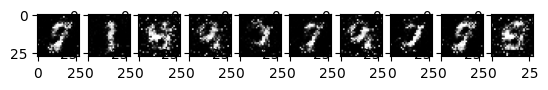

dloss: 0.276317, gloss: 1.298573


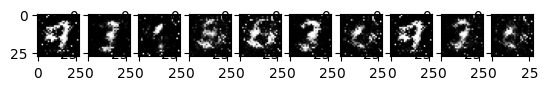

dloss: 0.273216, gloss: 1.853851


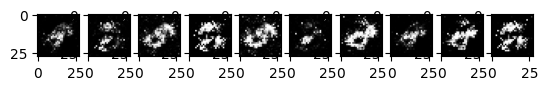

dloss: 0.300405, gloss: 2.199149


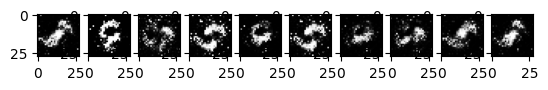

dloss: 0.429097, gloss: 1.035752


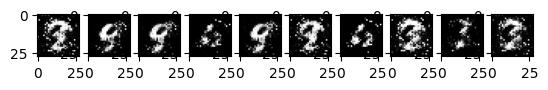

dloss: 0.399600, gloss: 0.932596


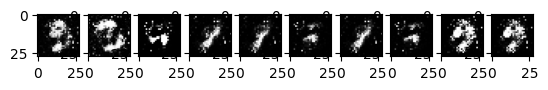

dloss: 0.357252, gloss: 2.078742


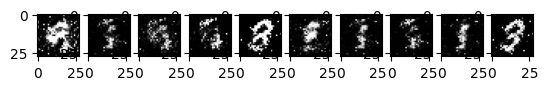

dloss: 0.520912, gloss: 4.022750


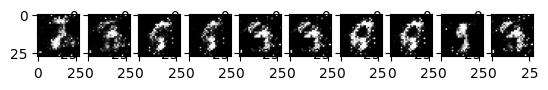

dloss: 0.294246, gloss: 2.655708


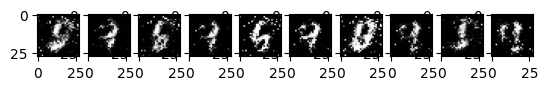

dloss: 0.214561, gloss: 2.026142


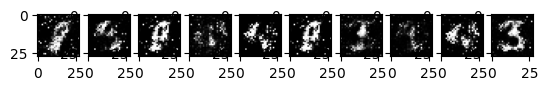

dloss: 0.200470, gloss: 1.931707


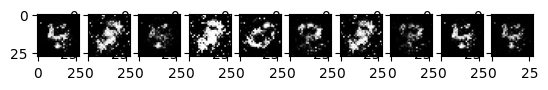

dloss: 0.236546, gloss: 1.659042


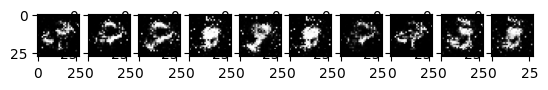

dloss: 0.283485, gloss: 1.777855


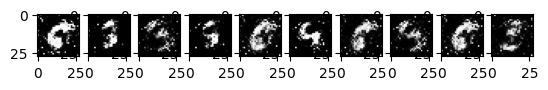

dloss: 0.322186, gloss: 1.322599


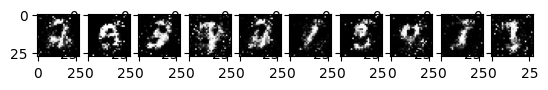

dloss: 0.765485, gloss: 3.435225


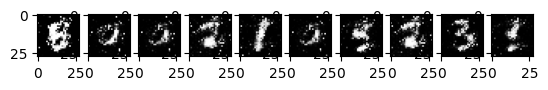

dloss: 0.150901, gloss: 2.410870


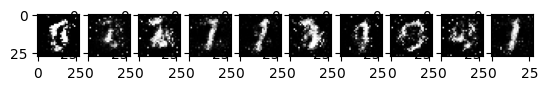

dloss: 0.223358, gloss: 2.530921


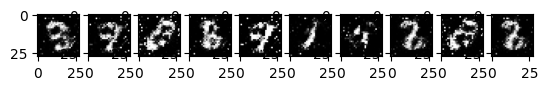

dloss: 0.326285, gloss: 2.880981


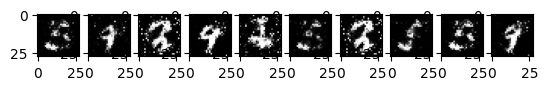

dloss: 0.247599, gloss: 1.705510


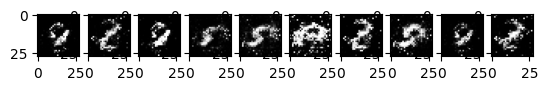

dloss: 0.449780, gloss: 3.343957


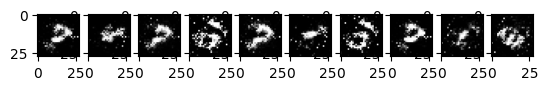

dloss: 0.244930, gloss: 1.405444


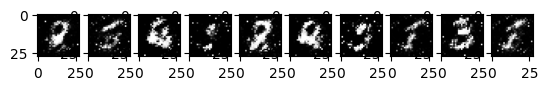

dloss: 0.203798, gloss: 1.836376


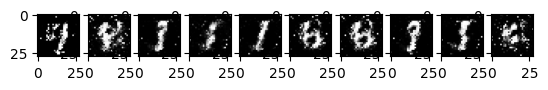

dloss: 0.311269, gloss: 2.003683


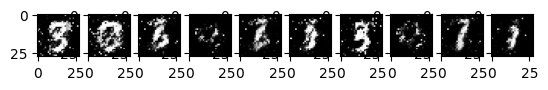

dloss: 0.229261, gloss: 2.216147


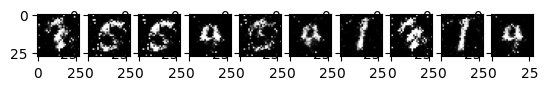

dloss: 0.203089, gloss: 2.548033


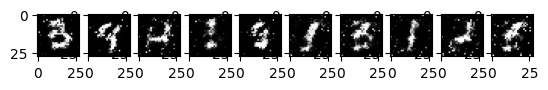

dloss: 0.246876, gloss: 1.998266


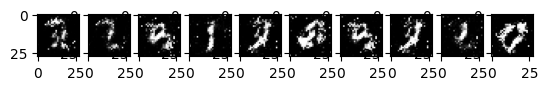

dloss: 0.200890, gloss: 1.688397


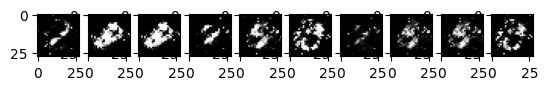

dloss: 0.104573, gloss: 2.424075


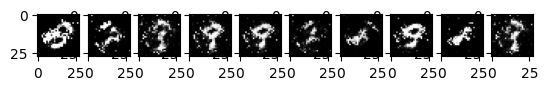

dloss: 0.255347, gloss: 1.398019


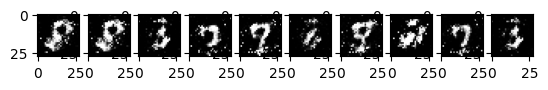

dloss: 0.226231, gloss: 1.617389


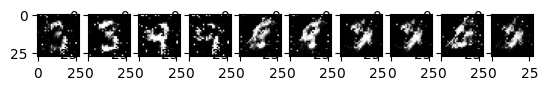

dloss: 0.868765, gloss: 5.014861


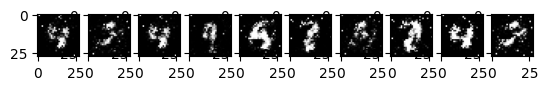

dloss: 0.230169, gloss: 1.491228


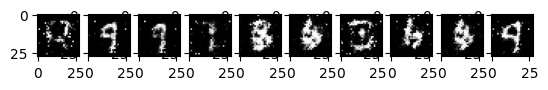

dloss: 0.171624, gloss: 1.845785


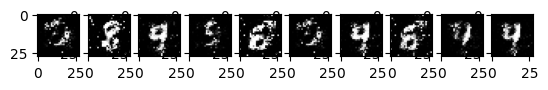

dloss: 0.147518, gloss: 2.322635


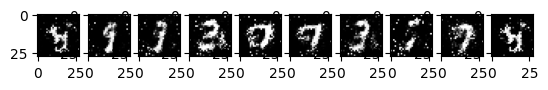

dloss: 0.183776, gloss: 1.903997


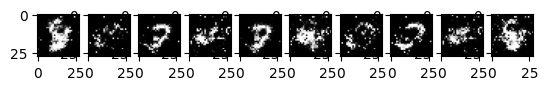

dloss: 0.199220, gloss: 2.448800


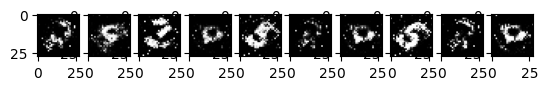

dloss: 0.202239, gloss: 2.049034


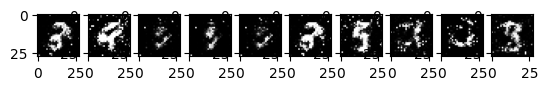

dloss: 0.176435, gloss: 1.654767


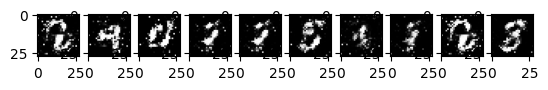

dloss: 0.285753, gloss: 2.787719


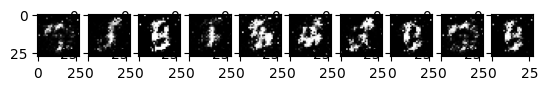

dloss: 0.152703, gloss: 2.061384


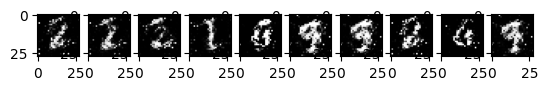

dloss: 0.270115, gloss: 2.936255


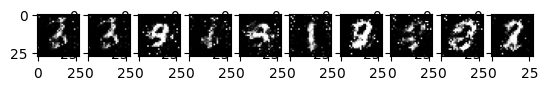

dloss: 0.248726, gloss: 1.214099


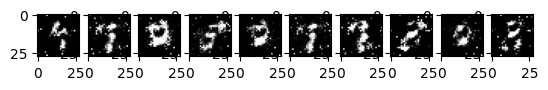

dloss: 0.126935, gloss: 2.345448


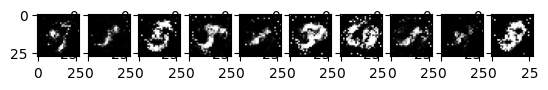

dloss: 0.176600, gloss: 2.021597


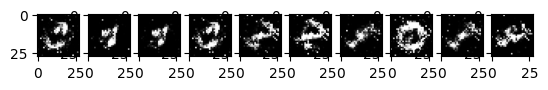

dloss: 0.146463, gloss: 2.201456


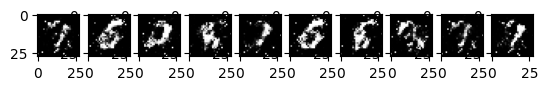

dloss: 0.200651, gloss: 1.845567


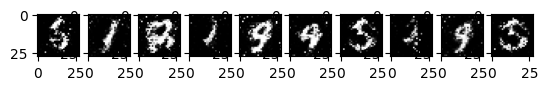

dloss: 0.280307, gloss: 2.752125


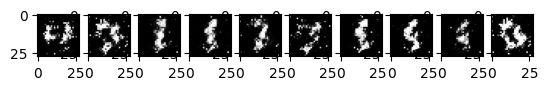

dloss: 0.295198, gloss: 1.288114


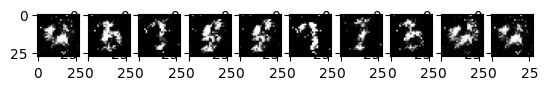

dloss: 0.468031, gloss: 2.675560


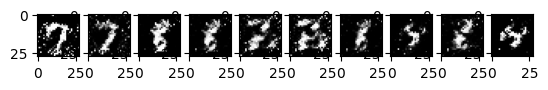

dloss: 0.198087, gloss: 2.196846


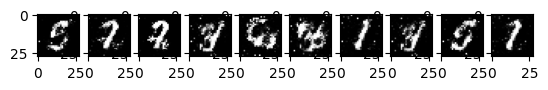

dloss: 0.135157, gloss: 2.160092


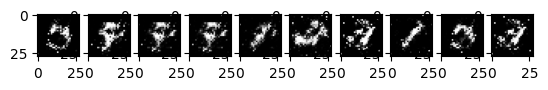

dloss: 0.310034, gloss: 2.170482


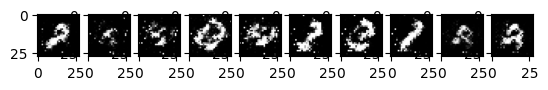

dloss: 0.234986, gloss: 1.755984


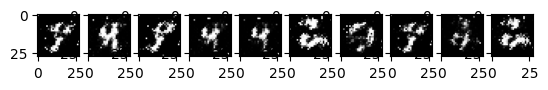

dloss: 0.172614, gloss: 2.042900


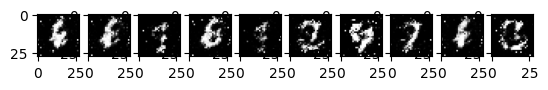

dloss: 0.476280, gloss: 3.281234


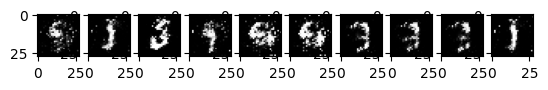

dloss: 0.225031, gloss: 1.698877


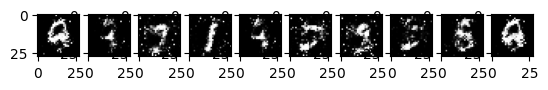

dloss: 0.273508, gloss: 2.696991


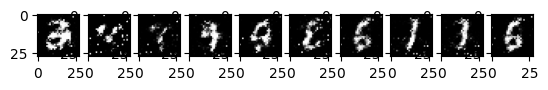

dloss: 0.373607, gloss: 0.904945


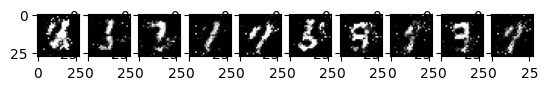

dloss: 0.137740, gloss: 2.261569


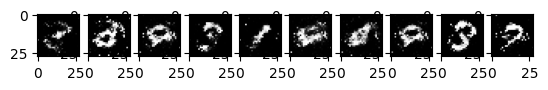

dloss: 0.298207, gloss: 1.461182


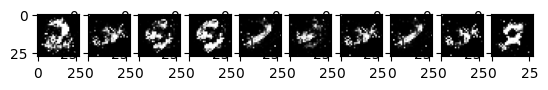

dloss: 0.350965, gloss: 1.159089


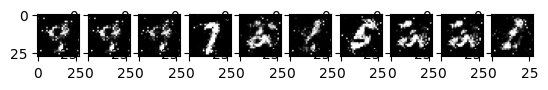

dloss: 0.228470, gloss: 2.605483


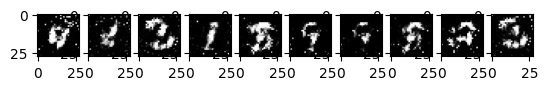

dloss: 0.261869, gloss: 1.923924


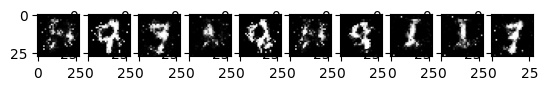

dloss: 0.182796, gloss: 2.147545


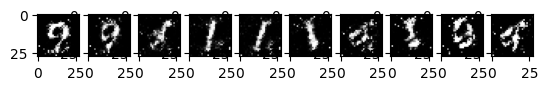

dloss: 0.249332, gloss: 2.550981


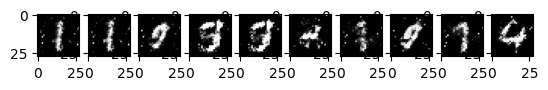

dloss: 0.238564, gloss: 1.835240


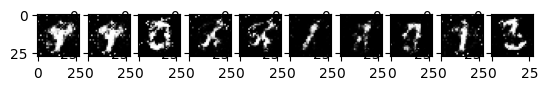

dloss: 0.179498, gloss: 1.913390


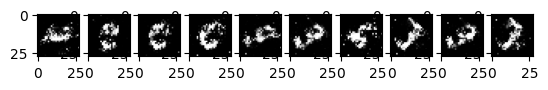

dloss: 0.274450, gloss: 2.485724


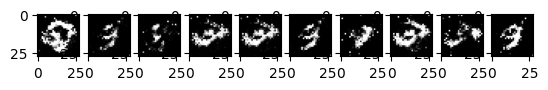

dloss: 0.167195, gloss: 2.206394


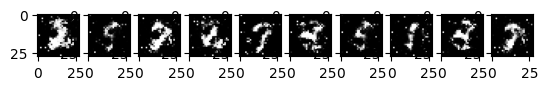

dloss: 0.180777, gloss: 3.116884


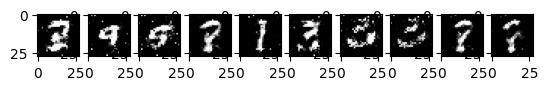

dloss: 0.279756, gloss: 2.474501


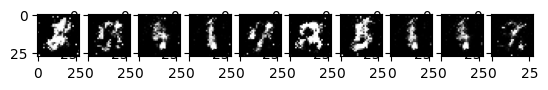

dloss: 0.181502, gloss: 1.745804


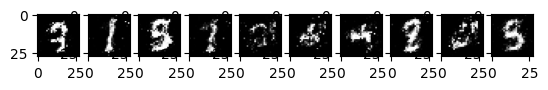

dloss: 0.258990, gloss: 1.680869


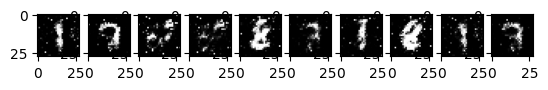

dloss: 0.200562, gloss: 2.030591


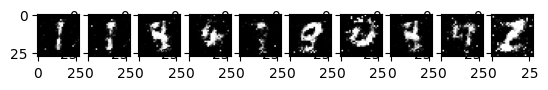

dloss: 0.120282, gloss: 2.544608


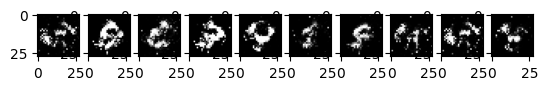

dloss: 0.163746, gloss: 3.033527


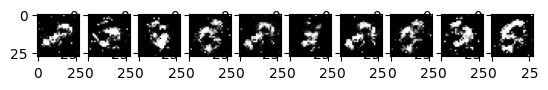

dloss: 0.284917, gloss: 1.781127


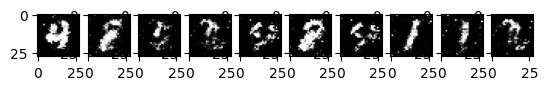

dloss: 0.205788, gloss: 1.899939


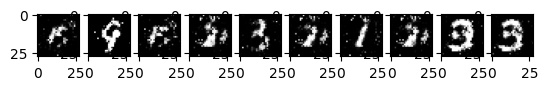

dloss: 0.381117, gloss: 2.232332


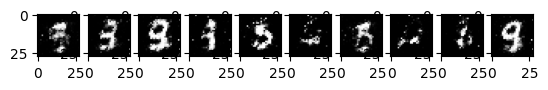

dloss: 0.231905, gloss: 2.207128


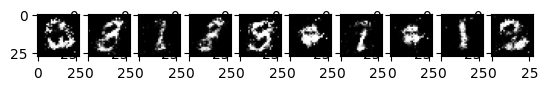

dloss: 0.343921, gloss: 1.536987


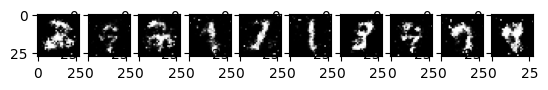

dloss: 0.234766, gloss: 2.644716


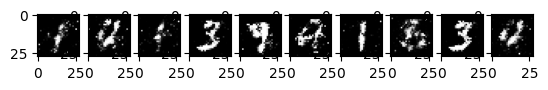

dloss: 0.155527, gloss: 2.622325


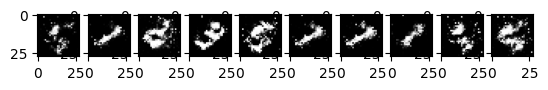

dloss: 0.235285, gloss: 1.822765


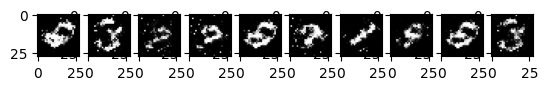

dloss: 0.289688, gloss: 1.537974


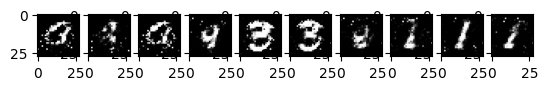

dloss: 0.219914, gloss: 1.710853


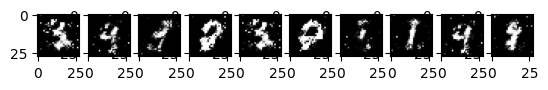

dloss: 0.226802, gloss: 2.765369


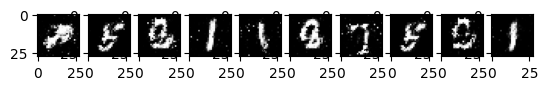

dloss: 0.245512, gloss: 1.938010


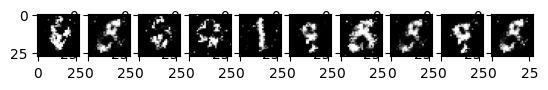

dloss: 0.731065, gloss: 3.994045


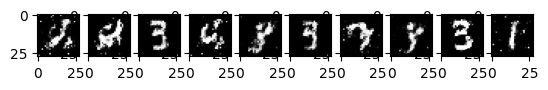

dloss: 0.249741, gloss: 1.721536


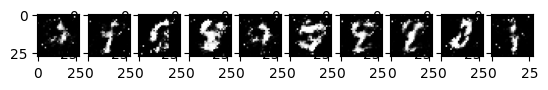

dloss: 0.168711, gloss: 2.211682


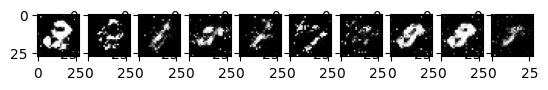

dloss: 0.326659, gloss: 1.252264


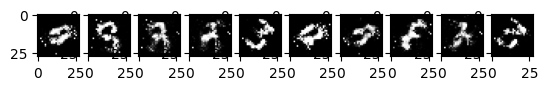

dloss: 0.332651, gloss: 1.483265


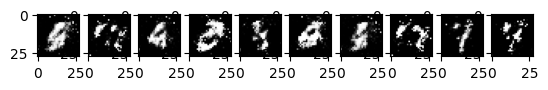

dloss: 0.214104, gloss: 2.039187


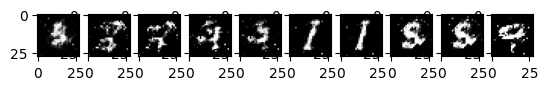

dloss: 0.330436, gloss: 1.528603


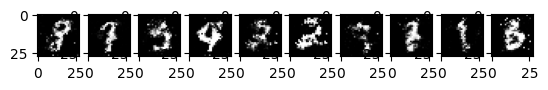

dloss: 0.207186, gloss: 2.157230


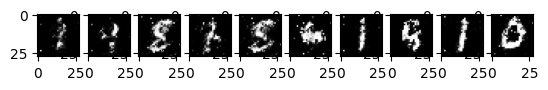

dloss: 0.245617, gloss: 2.054666


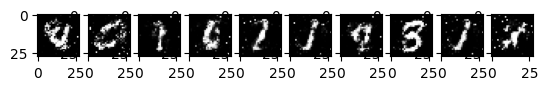

dloss: 0.295379, gloss: 1.987640


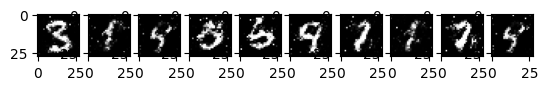

dloss: 0.152952, gloss: 2.336230


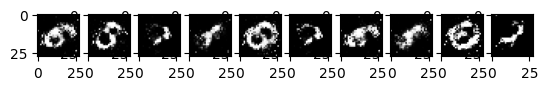

dloss: 0.250256, gloss: 1.974084


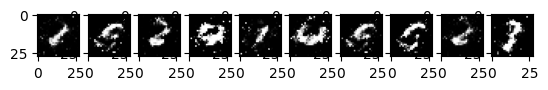

dloss: 0.359616, gloss: 1.518608


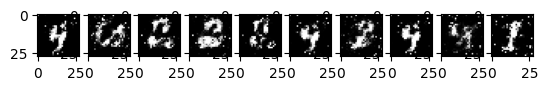

dloss: 0.197897, gloss: 3.233319


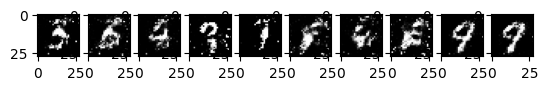

dloss: 0.364016, gloss: 4.239912


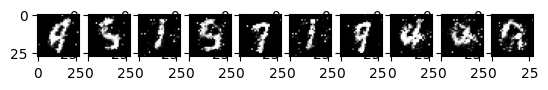

dloss: 0.180558, gloss: 1.979442


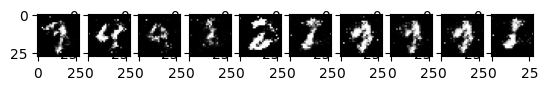

dloss: 0.309740, gloss: 2.537499


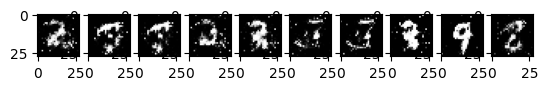

dloss: 0.162950, gloss: 2.229950


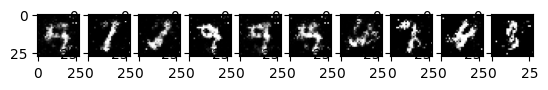

dloss: 0.107547, gloss: 2.811327


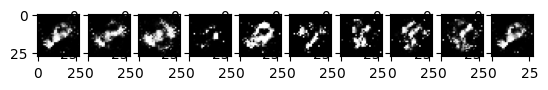

dloss: 0.233548, gloss: 3.079688


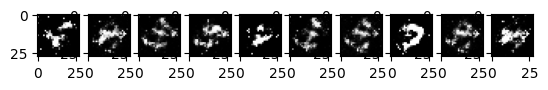

dloss: 0.213789, gloss: 2.384585


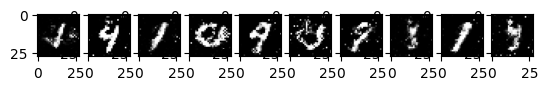

dloss: 0.143756, gloss: 2.845801


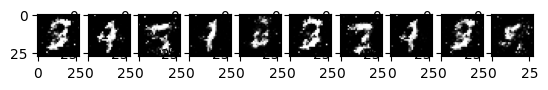

dloss: 0.288693, gloss: 1.519178


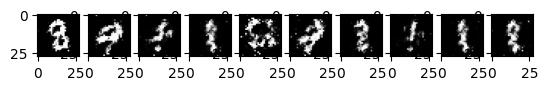

dloss: 0.695346, gloss: 4.241298


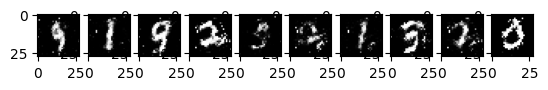

dloss: 0.257655, gloss: 2.466633


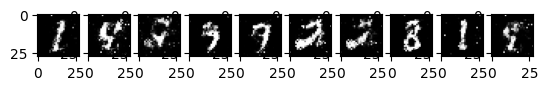

dloss: 0.225244, gloss: 2.192213


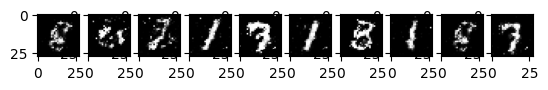

dloss: 0.142173, gloss: 2.532564


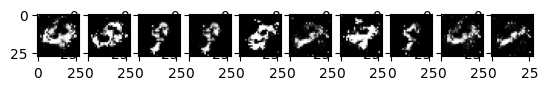

dloss: 0.897544, gloss: 4.831331


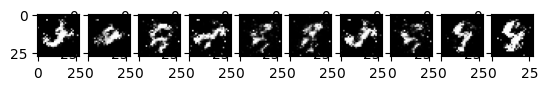

dloss: 0.261083, gloss: 1.739829


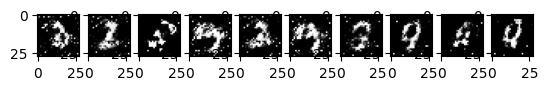

dloss: 0.181424, gloss: 2.162947


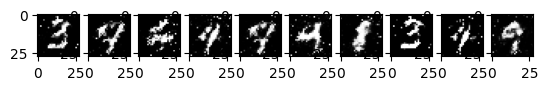

dloss: 0.251166, gloss: 3.099144


KeyboardInterrupt: 

In [3]:
torch.manual_seed(1337)

zdim = 100

learning_rate = 1e-4
discriminator = SimpleDiscriminator()
generator = SimpleGenerator(zdim)

betas = (0.5, 0.999)
d_opt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
g_opt = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)

print(features.shape)
batch_size = 128

print(generator.model)

gan_loss = nn.BCELoss()
fixed_latent = torch.randn(batch_size, zdim)
for epoch in range(1000):
    print("epoch", epoch)
    for batch in range(features.shape[0] // batch_size):
        discriminator.train()
        generator.train()

        reals = features[batch * batch_size: (batch + 1) * batch_size].unsqueeze(1)
        g_opt.zero_grad()
        d_opt.zero_grad()

        latents = torch.randn(batch_size, zdim)
        generated = generator(latents)

        f_pred = discriminator(generated)
        g_loss = gan_loss(f_pred, torch.ones_like(f_pred))
        g_loss.backward()
        g_opt.step()

        d_opt.zero_grad()
        g_opt.zero_grad()
        r_pred = discriminator(reals)
        f_pred = discriminator(generated.detach())
        f_loss = gan_loss(f_pred, torch.zeros_like(f_pred))
        r_loss = gan_loss(r_pred, torch.ones_like(r_pred))
        d_loss = (f_loss + r_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        prev = None
        badgrad = False
        for idx, p in enumerate(generator.parameters()):

            if p.grad is not None:
                g = p.grad.isnan().any().item()
                if g:
                    # if prev:
                    #     print("perkele", prev.grad)
                    # else:
                    #     print("first parameter", p)
                    # print("fprednan", f_pred.isnan().any(), torch.min(f_pred), torch.max(f_pred))
                    # print("glossnan", g_loss.isnan().any(), g_loss)
                    # print("generatednan", generated.isnan().any())
                    # print("gradisnan", p.grad.isnan().any())
                    # print("idx", p.name, idx)
                    # layers = list(generator.model.children())
                    # print(layers[2].weight)
                    # print(layers[2].weight.grad)
                    # display(torchviz.make_dot(g_loss))
                    badgrad = True
        if not badgrad:
            g_opt.step()
        else:
            print("saving the day")
            #raise KeyboardInterrupt

            
        if batch % 200 == 0:
            # grad_min = 1000000
            # grad_max = -1000000

            # avg_grad_mag = 0
            # num_params = 0
            # for p in generator.parameters():
            #     if p.grad is not None:
            #         g = p.grad.abs().mean().item()
            #         grad_min = min(grad_min, torch.min(p.grad).item())
            #         grad_max = max(grad_max, torch.max(p.grad).item())
            #         avg_grad_mag += g
            #         num_params += 1
            #     else:
            #         print("had no grad")

            # avg = avg_grad_mag / num_params
            # print("generator avg grad magnitude", avg, num_params, avg_grad_mag)
            # print("min, max", grad_min, grad_max)
            f, axrr = plt.subplots(1, 10)
            samples = generator(torch.randn(10, zdim))
            for i in range(10):
                img = samples[i].squeeze(0) / 127 + 127.5
                axrr[i].imshow(img.detach().cpu().numpy(), cmap='gray')
            plt.show()
            print(f"dloss: {d_loss.item():5f}, gloss: {g_loss.item():5f}")




notes:

generator avg grad magnitude 0.0008939449720435736
generator avg grad magnitude nan